# PSF deconvolution with Neural Networks
This problem aims to tackle the processing of blurry and noisy telescope image by training neural networks to deconvolve an image's PSF (Point Spread Function)

In [19]:
import sys
sys.path.append("../utils/")
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.desi_image_downloader import get_image
from utils.display_utils import display
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel

plt.style.use("science")

In [20]:
# CONSTANTS
RA_bounds = (115, 260)
DEC_bounds = (0, 80)
npix=255

## Legacy Survey data

We will be working with cutouts from the DESI Legacy Imaging Survey, a catalogue of light in multiple bands from very wide areas of the sky.

TODO: toss images with pixels above saturation mask value, and those with sum of all pixels below threshold

### A random patch of sky
Let's select random RA and DEC coordinates within the intervals covered by the survey and see what comes up:

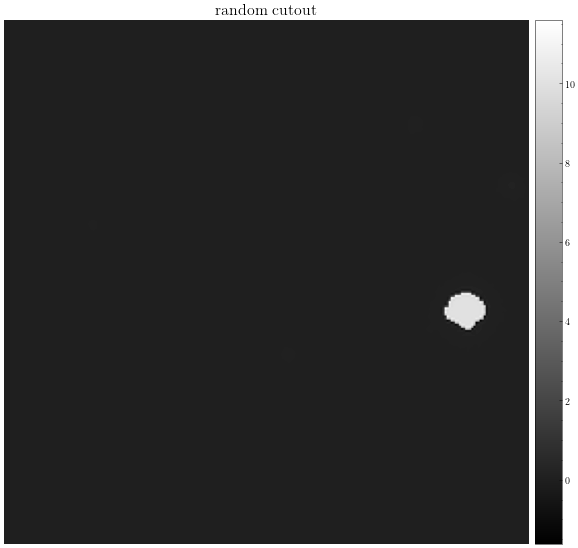

(<matplotlib.image.AxesImage at 0x7f2581c038e0>,
 Text(0.5, 1.0, 'random cutout'))

In [21]:
RA = np.random.uniform(low=RA_bounds[0], high=RA_bounds[1])
DEC = np.random.uniform(low=DEC_bounds[0], high=DEC_bounds[1])

rand_cutout, header = get_image(RA, DEC, size=npix)

display(rand_cutout, axis=False, title="random cutout")

### A bright star
Let's now look at the coordinates of Pollux, a star in the Gemini constellation and one of the brightest in the sky:

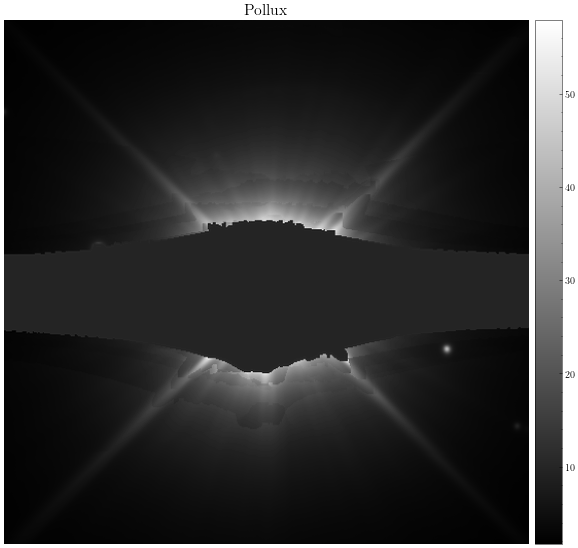

(<matplotlib.image.AxesImage at 0x7f258219cfd0>, Text(0.5, 1.0, 'Pollux'))

In [22]:
# Pollux coordinates
RA = 116.3260
DEC = 28.0265

pollux_cutout, header = get_image(RA, DEC, size=npix*2)

display(pollux_cutout, axis=False, title="Pollux")

## Selecting good data
We would like to avoid dark patches without objects, as well as patches containing bright stars or their masks. We can filter our selection with flux thresholds:

In [23]:
def square_mask(aperture_frac=0.75):
	
	window = np.zeros(npix)
	aperture = npix * aperture_frac
	cutout_side = np.arange(-npix/2, npix/2)
	
	r = np.abs(cutout_side)
	mask = r > aperture / 2
	window[mask == 1.0] = 0.
	window[mask == 0.0] = 1.0
	window = np.outer(window, window)

	return window


def clean_selection(min_sum=25., sat_pixel=9., aperture_frac=1.):
	"""
	Fetch a random cutout from the Legacy Survey, ensuring that some 
	quality conditions are met
	
	:param min_sum: lower threshold for the sum of all pixel values
	:param sat_pixel: saturation value of bright star masks
	:param aperture_frac: fraction of cutout defining a centered square mask, in which we check for sufficient signal
	"""
	mask = square_mask(aperture_frac)
	
	while True:
		RA = np.random.uniform(low=RA_bounds[0], high=RA_bounds[1])
		DEC = np.random.uniform(low=DEC_bounds[0], high=DEC_bounds[1])
		
		cutout, header = get_image(RA, DEC, size=npix)
		
		if np.sum(mask * cutout) > min_sum and np.all(cutout < sat_pixel):
			break
		print("bad cutout, retrying...")
		
	return cutout

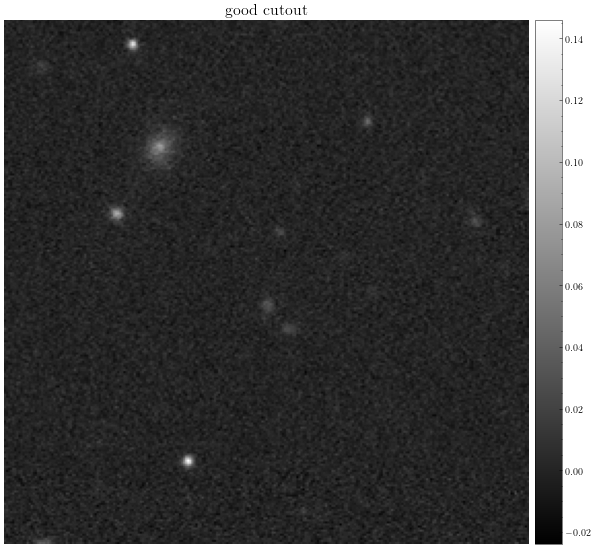

(<matplotlib.image.AxesImage at 0x7f258222e5e0>, Text(0.5, 1.0, 'good cutout'))

In [24]:
good_cutout = clean_selection(aperture_frac=0.75)

display(good_cutout, axis=False, title="good cutout")

## Convolving with a gaussian PSF and adding noise


In [25]:
def corrupt_image(image, psf="gaussian", width=5, noise="gaussian", noise_scale=0.02):

	# PSF first
	if psf is not None:
		if psf == "gaussian":
			kernel = Gaussian2DKernel(x_stddev=width, x_size=npix, y_size=npix)
		else:
			raise ValueError(f"psf of type '{psf}' not implemented")
		
		if kernel.shape[0] < npix // 10:
			image = convolve(image, kernel)     # direct convolution, better for small kernels
		else:
			image = convolve_fft(image, kernel) # FFT convolution, better for large kernels
			
	# Noise
	if noise is not None:
		if noise == "poisson":
			mask = np.random.poisson(noise_scale, size=(npix, npix))
		elif noise == "gaussian":
			mask = np.random.normal(loc=0., scale=noise_scale*np.max(np.abs(image)), size=(npix, npix))
		else:
			raise ValueError(f"noise of type '{noise}' not implemented")
		image += mask

	return image, kernel

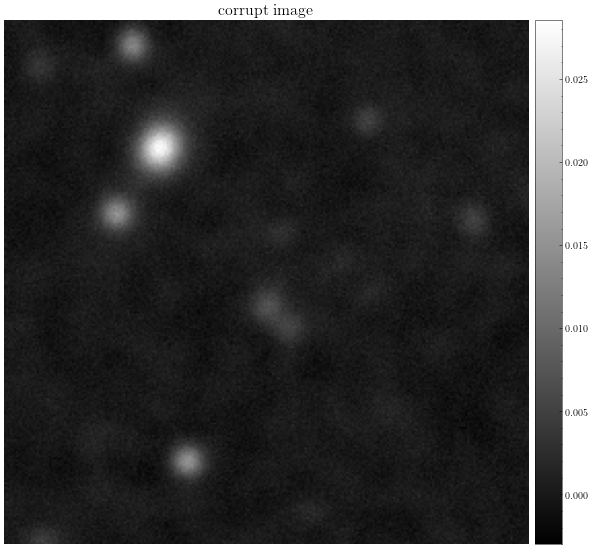

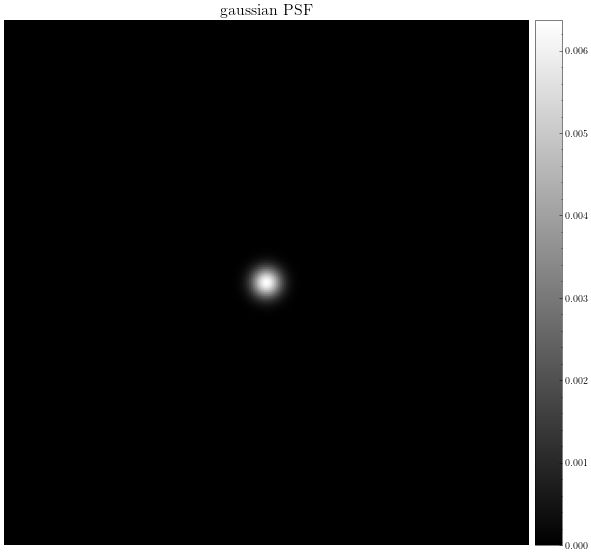

(<matplotlib.image.AxesImage at 0x7f2581c3dc70>,
 Text(0.5, 1.0, 'gaussian PSF'))

In [26]:
psf = "gaussian"
noise = "gaussian"

bad_image, kernel = corrupt_image(good_cutout, psf=psf, noise=noise)

display(bad_image, axis=False, title="corrupt image")
display(kernel, axis=False, title=f"{psf} PSF")